In [8]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import patsy 
import math
from lifelines import KaplanMeierFitter

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
#Add some formatting options so you can always see your data
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('max_colwidth', 100000)

In [10]:
sepsis_data = pd.read_csv("./sepsis3-df-no-exclusions.csv")
sepsis_data.head()

,subject_id,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,blood_culture_time,blood_culture_positive,age,gender,is_male,ethnicity,race_white,race_black,race_hispanic,race_other,metastatic_cancer,diabetes,height,weight,bmi,first_service,hospital_expire_flag,thirtyday_expire_flag,icu_los,hosp_los,sepsis_angus,sepsis_martin,sepsis_explicit,septic_shock_explicit,severe_sepsis_explicit,sepsis_nqf,sepsis_cdc,sepsis_cdc_simple,elixhauser_hospital,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,composite_outcome,blood culture,suspicion_poe,abx_poe,sepsis-3,sofa>=2
0,55973,200001,152234,1,2181-11-25 19:06:12,2181-11-28 20:59:25,metavision,2181-11-18 11:10:00,7.330694,BLOOD CULTURE,0.0,2181-11-18 00:00:00,2181-11-24 00:12:00,1,61.0499,F,0,ASIAN - ASIAN INDIAN,0,0,0,1,0,1,170.18,61.0,21.062640,MED,0,0,3.0786,15.901389,0,0,0,0,0,0,0,0,3,0,6,7,3,2,1.0,0.0,1.0,1,0,0,0,1,0,0,1,True,True,True,1,1
1,27513,200003,163557,1,2199-08-02 19:50:04,2199-08-08 17:09:18,carevue,2199-08-02 21:02:00,-0.049954,BLOOD CULTURE,1.0,2199-08-02 00:00:00,2199-08-02 21:02:00,1,48.2940,M,1,WHITE,1,0,0,0,0,0,177.80,77.0,24.357192,SURG,0,0,5.8884,20.081944,1,1,0,0,0,1,1,1,0,1,6,3,4,2,1.0,0.0,1.0,0,0,0,1,0,0,0,1,True,True,True,1,1
2,10950,200006,189514,1,2159-09-03 11:28:14,2159-09-04 19:08:10,carevue,NaN,NaN,NaN,NaN,NaN,2159-09-03 09:00:00,1,54.0710,M,1,OTHER,0,0,0,1,0,1,165.10,82.4,30.229646,MED,0,0,1.3194,2.304167,0,0,0,0,0,0,0,0,-5,1,1,2,2,2,1.0,0.0,1.0,1,0,0,1,0,0,0,0,True,False,False,0,0
3,20707,200007,129310,1,2109-02-17 10:03:37,2109-02-18 17:03:12,carevue,NaN,NaN,NaN,NaN,NaN,NaN,0,43.3439,M,1,WHITE,1,0,0,0,0,0,177.80,126.0,39.857223,CMED,0,0,1.2914,3.239583,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,False,False,False,0,0
4,29904,200009,129607,1,2189-11-30 10:34:32,2189-12-02 14:17:37,carevue,NaN,NaN,NaN,NaN,2189-11-30 00:00:00,NaN,0,47.5548,F,0,WHITE,1,0,0,0,0,0,161.29,87.2,33.519814,CSURG,0,0,2.1549,6.177083,0,0,0,0,0,0,0,0,-4,1,3,4,4,2,1.0,0.0,1.0,0,0,1,1,0,0,0,0,False,False,True,0,1


In [11]:
sepsis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 62 columns):
subject_id                           61532 non-null int64
icustay_id                           61532 non-null int64
hadm_id                              61532 non-null int64
excluded                             61532 non-null int64
intime                               61532 non-null object
outtime                              61522 non-null object
dbsource                             61532 non-null object
suspected_infection_time_poe         35389 non-null object
suspected_infection_time_poe_days    35389 non-null float64
specimen_poe                         35389 non-null object
positiveculture_poe                  35389 non-null float64
antibiotic_time_poe                  41056 non-null object
blood_culture_time                   46140 non-null object
blood_culture_positive               61532 non-null int64
age                                  61532 non-null float64
gender  

## Preprocessing: removing patients with metastatic cancer and diabetes + removing patients with null factors in what we're analyzing

In [12]:
sepsis_data.intime = pd.to_datetime(sepsis_data.intime)
sepsis_data.outtime = pd.to_datetime(sepsis_data.outtime)

### Preprocessing pt 1
# Remove patients with metastatic cancer and diabetes
sepsis_data_rm = sepsis_data[(sepsis_data["diabetes"] == 0) & (sepsis_data["metastatic_cancer"] == 0)]

### Preprocessing pt 2
# Remove patients with null values in factors we are analyzing.
sepsis_mod = sepsis_data_rm.dropna(subset=["age","gender","weight","race_white","race_black","race_hispanic","race_other"]) # Could change later. 

#print(sepsis_mod[sepsis_mod['race_white']==1].shape) ====> 24013
#print(sepsis_mod[sepsis_mod['race_black']==1].shape) # ====> 2611
#print(sepsis_mod[sepsis_mod['race_hispanic']==1].shape) # ====> 1008
#print(sepsis_mod[sepsis_mod['race_other']==1].shape) # ====> 5230
# print(sepsis_mod.columns)

In [13]:


time_baseline = sepsis_mod.sort_values(by='intime').intime.iloc[0]

sepsis_mod['corrected_intime'] = (sepsis_mod.intime - time_baseline).dt.total_seconds()
sepsis_mod['corrected_outtime'] = (sepsis_mod.outtime - time_baseline).dt.total_seconds()
sepsis_mod['stay_duration_sec'] = (sepsis_mod.corrected_outtime - sepsis_mod.corrected_intime)
sepsis_mod['stay_duration_days'] = sepsis_mod.stay_duration_sec/(3600*24)
#sepsis_mod = sepsis_mod.sort_values(by='corrected_intime')

/afs/crc.nd.edu/user/s/scattana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/afs/crc.nd.edu/user/s/scattana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/afs/crc.nd.edu/user/s/scattana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [14]:

# Do preprocessing for what will become different data subsets.

sepsis_mod2 = sepsis_mod[sepsis_mod['race_black']==1]
sepsis_mod3 = sepsis_mod[sepsis_mod['race_hispanic']==1]
sepsis_mod4 = sepsis_mod[sepsis_mod['race_white']==1]
sepsis_mod5 = sepsis_mod[sepsis_mod['race_other']==1]
sepsis_mod6 = sepsis_mod


# Initialize what will eventually become dropdown menus

global race 
race = "Any"
global age 
age = 25
global weight 
weight = 100
global gender 
gender = "Any"


def changeDiagram(race, age, weight, gender):
    print("calling changeDiagram with race = {}, age = {}, weight = {}, gender = {}".format(race, age, weight, gender))
    if race == "African American":
        mod_adjustment = sepsis_mod2[(sepsis_mod2['age'] >= age) & (sepsis_mod2['weight'] >= weight)]
    elif race == "Hispanic":
        mod_adjustment = sepsis_mod3[(sepsis_mod3['age'] >= age) & (sepsis_mod3['weight'] >= weight)]
    elif race == "White":
        mod_adjustment = sepsis_mod4[(sepsis_mod4['age'] >= age) & (sepsis_mod4['weight'] >= weight)]
    elif race == "Any":
        mod_adjustment = sepsis_mod[(sepsis_mod['age'] >= age) & (sepsis_mod['weight'] >= weight)]
    elif race == "Other":
        mod_adjustment = sepsis_mod5[(sepsis_mod5['age'] >= age) & (sepsis_mod5['weight'] >= weight)]
        
        
    TTE = mod_adjustment['stay_duration_days']
    EventFlg = mod_adjustment['hospital_expire_flag']
    kmf = KaplanMeierFitter()
    return kmf.fit(TTE, event_observed=EventFlg,label='Full Data')
    

In [15]:
#kmf.survival_function_.plot()

### PLOT LIFELINES NOT WORKING!!! WTF

In [16]:
from lifelines.plotting import plot_lifetimes


#This function takes the following paramaters:
#plot_lifetimes(Time-To-Event-Series, event_observed=Event-Observed-Series)
# plt.xlabel("time")
# plt.title("Timespans of patient mortality")
#plot_lifetimes(TTE, event_observed=EventFlg) <-- THIS THROWS A KEY = 0 ERROR :/

In [17]:
%matplotlib inline


# Slider Demo


Using the slider widget to control visual properties of your plot.

In this example, a slider is used to choose the frequency of a sine
wave. You can control many continuously-varying properties of your plot in
this way.



In [18]:
# %matplotlib inline

from IPython.display import clear_output
# import numpy as np
# import matplotlib.pyplot as plt

# def plot(amplitude, color):
#     fig, ax = plt.subplots(figsize=(4, 3),
#                            subplot_kw={'axisbg':'#EEEEEE',
#                                        'axisbelow':True})
#     ax.grid(color='w', linewidth=2, linestyle='solid')
#     x = np.linspace(0, 10, 1000)
#     ax.plot(x, amplitude * np.sin(x), color=color,
#             lw=5, alpha=0.4)
#     ax.set_xlim(0, 10)
#     ax.set_ylim(-1.1, 1.1)
#     return fig

In [19]:
# from __future__ import print_function
# from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# def f(age):
    
#     return [age,1,3,5]

# interact(f, age=widgets.IntSlider(min=-20,max=30,step=1,value=10));

In [20]:
# a = widgets.IntSlider()
# b = widgets.Dropdown()
# c = widgets.IntSlider()
# ui = widgets.HBox([a, b, c])
# def f(a, b, c):
#     print((a, b, c))

# out = widgets.interactive_output(f, {'a': a, 'b': [('one', 10), ('two', 20)], 'c': c})

# display(ui, out)

In [21]:
#race = 
# a= widgets.Dropdown(
#     options=['1', '2', '3'],
#     value='2',
#     description='Number:',
#     disabled=False,
# )

# display(a)

# def on_change(change):
#     if change['type'] == 'change' and change['name'] == 'value':
#         print "changed to %s" % change['new']
        
# a.observe(on_change)

# display(a)

In [22]:
r = widgets.Dropdown(
    options=['Any','White', 'African American', 'Hispanic', 'Other'],
    value='Any',
    description='Race:',
)


a = widgets.IntSlider(
    value=25,
    min=10,
    max=80,
    step=1,
    description='Age:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


w = widgets.IntSlider(
    value = 100,
    min = 50, 
    max = 300,
    step = 1,
    description="Weight:",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
      

)


g = widgets.Dropdown(
    options=['Any','Male', 'Female'],
    value='Any',
    description='Gender:',
)


Dropdown(description='Race:', options=('Any', 'White', 'African American', 'Hispanic', 'Other'), value='Any')

IntSlider(value=25, continuous_update=False, description='Age:', max=80, min=10)

IntSlider(value=100, continuous_update=False, description='Weight:', max=300, min=50)

Dropdown(description='Gender:', options=('Any', 'Male', 'Female'), value='Any')

calling changeDiagram with race = Any, age = 25, weight = 100, gender = Any


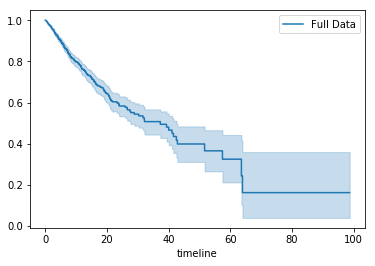

In [23]:
def on_change_race(change):
    if change['type'] == 'change' and change['name'] == 'value':
        race = change['new']
        clear_output()
        display(r,a,w,g)
        age = a.value
        weight = w.value
        gender = g.value
        new_plot = changeDiagram(race,age,weight,gender)
        new_plot.plot()
        print(race)
        
        
        # Generate a new Kaplan Meier curve here. 

r.observe(on_change_race)

#display(r)


def on_change_age(change):
    if change['type'] == 'change' and change['name'] == 'value':
        age = change['new']
        clear_output()
        display(r,a,w,g)
        race = r.value
        weight = w.value
        gender = g.value
        new_plot = changeDiagram(race,age,weight,gender)
        new_plot.plot()
        print(age)
        # Generate a new Kaplan Meier curve here. 

a.observe(on_change_age)


def on_change_weight(change):
    if change['type'] == 'change' and change['name'] == 'value':
        weight = change['new']
        clear_output()
        display(r,a,w,g)
        race = r.value
        weight = w.value
        age = a.value
        new_plot = changeDiagram(race,age,weight,gender)
        new_plot.plot()
        print(weight)
        
w.observe(on_change_weight)


def on_change_gender(change):
    if change['type'] == 'change' and change['name'] == 'value':
        gender = change['new']
        clear_output()
        display(r,a,w,g)
        race = r.value
        age = a.value
        weight = w.value
        new_plot = changeDiagram(race,age,weight,gender)
        new_plot.plot()
        print(gender)

g.observe(on_change_gender)




        
display(r,a, w, g)
new_plot = changeDiagram(race,age,weight,gender)
new_plot.plot()








In [24]:
#display(sepsis_mod.age)